In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        continue
        #print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [3]:
# 랜덤 시드 고정
import random
import librosa
import matplotlib.pyplot as plt
from tqdm import tqdm
import time

seed = 42

random.seed(seed)
np.random.seed(seed)
os.environ["PYTHONHASHSEED"] = str(seed)

# 0. 음악 데이터 재생

In [4]:
# Ipython 라이브러리를 이용해 학습에 사용될 음성을 직접 들어볼 수 있습니다.
from IPython.display import Audio, display

filename = '/kaggle/input/2023-ml-project4/train/train_000.wav'
y, sr = librosa.load(filename)
audio_wdt = Audio(data=y,rate=sr)
display(audio_wdt)

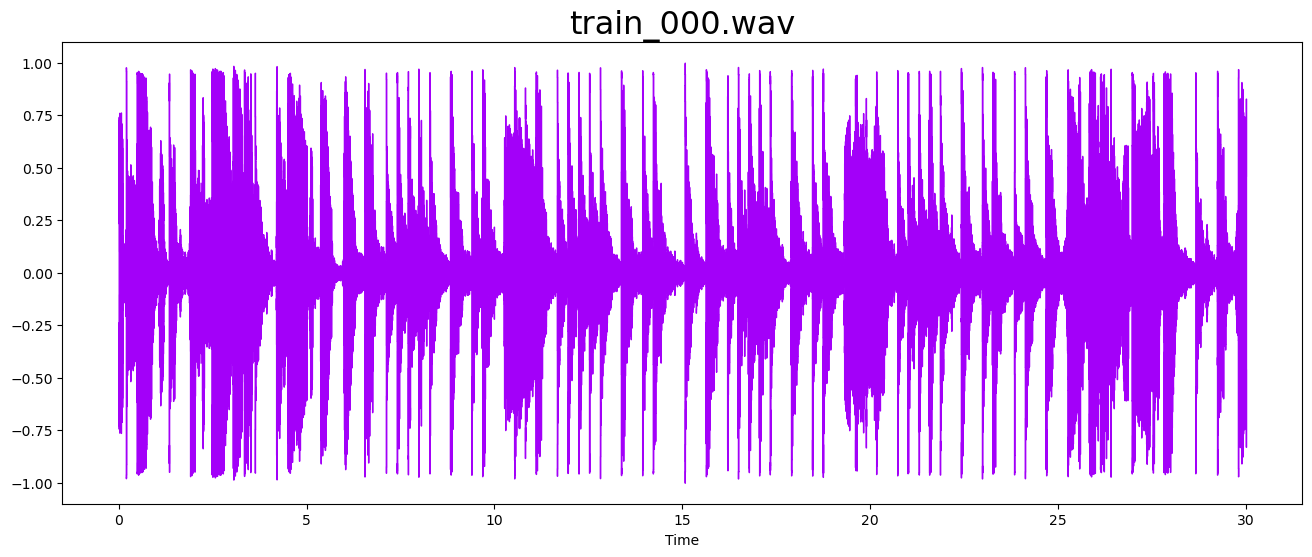

In [5]:
# visualization

audio_file, _ = librosa.effects.trim(y)

plt.figure(figsize = (16, 6))
librosa.display.waveshow(y = audio_file, sr = sr, color = "#A300F9");
plt.title("train_000.wav", fontsize = 23);

# 1. 학습 및 제출에 사용할 csv 파일 불러오기

In [6]:
# 학습할 음악들의 장르 정답 csv 파일 불러오기
train_info_csv = pd.read_csv('/kaggle/input/2023-ml-project4/train_labels.csv')

# 제출에 사용할 csv 파일 불러오기
submit = pd.read_csv('/kaggle/input/2023-ml-project4/submit.csv')
test_info_csv = submit['id']

In [7]:
# 어떤 장르들을 분류해야 하는지 확인해보기
train_info_csv['genre'].unique()

array(['rock', 'country', 'metal', 'hiphop', 'pop', 'classical', 'disco',
       'reggae', 'blues', 'jazz'], dtype=object)

In [8]:
train_info_csv

,id,genre
0,train_000.wav,rock
1,train_001.wav,country
2,train_002.wav,metal
3,train_003.wav,hiphop
4,train_004.wav,pop
...,...,...
795,train_795.wav,metal
796,train_796.wav,blues
797,train_797.wav,reggae
798,train_798.wav,metal


# 2. 데이터 불러오기 및 Handcrafted-Feature 추출

## Empty Module #1: extract_rhythm_features()
첫 번째 Empty Module에서는 rhythm 도메인의 두 가지 feature인 autocorrelation tempogram과 fourier tempogram을 추출합니다.  
단, 첫 번째 Empty Module에서는 **librosa.load() 함수를 통해 얻은 time-series (y, sr)를 입력으로 주어 두 feature를 얻는 것을 목표**로 합니다.

(1-1) **librosa.load()**: extract_rhythm_features() 함수의 인자로 넘겨 받은 file_path에 대하여 1초 당 22050개의 샘플을 추출한 time-series를 load합니다.  
(1-2) **librosa.onset.onset_strength()**: 앞서 load한 time-series를 함수의 입력으로 주어 onset_envelope를 추출합니다.  
(1-3) **librosa.feature.tempogram()**: 앞서 추출한 onset_envelope와 sr을 함수의 입력으로 주어 autocorrelation tempogram feature를 추출합니다.  
(1-4) autocorrelation tempogram에 대해 시간 축으로 평균을 내고 절대값을 취해 복소수를 제거함으로써 tempogram_feature를 얻습니다.   

각 단계별 세부 내용은 아래 함수를 참고하시기 바랍니다.

In [9]:
# Empty Module #1
def extract_rhythm_features(file_path):
    # 반환할 feature list 선언
    feature = []
    
    y, sr = librosa.load(file_path, sr=22050) # sr은 sampling rate, y는 time-series
    onset_envelope = librosa.onset.onset_strength(y=y, sr=sr) # onset_envelope함수는 onset의 강도를 반환합니다.
    
    
    # autocorrelation tempogram
    tempogram = librosa.feature.tempogram(onset_envelope=onset_envelope, sr=sr) # tempogram은 onset_envelope의 템포를 추출합니다.                      
    tempogram_feature = np.abs(np.mean(tempogram, axis=1)) # (384, 1293) -> (384, ), 복소수를 없애기 위해 절대값 처리
    
    # fourier tempogram
    fourier_tempogram = librosa.feature.fourier_tempogram(onset_envelope=onset_envelope,sr=sr)
    fourier_tempogram_feature = np.abs(np.mean(tempogram, axis=1))
    
    feature = np.concatenate([tempogram_feature, fourier_tempogram_feature], axis=0)
    return feature

In [10]:
# file_path = '/kaggle/input/2023-ml-project4/train/train_000.wav'
# y, sr = librosa.load(file_path, sr=22050)
# onset_envelope = librosa.onset.onset_strength(y=y, sr=sr) # onset_envelope함수는 onset의 강도를 반환합니다.
# tempogram = librosa.feature.tempogram(onset_envelope=onset_envelope, sr=sr) # tempogram은 onset_envelope의 템포를 추출합니다.                      
# tempogram_feature = np.abs(np.mean(tempogram, axis=1)) # (384, 1293) -> (384, ), 복소수를 없애기 위해 절대값 처리

# # fourier tempogram
# fourier_tempogram = librosa.feature.fourier_tempogram(onset_envelope=onset_envelope,sr=sr)
# fourier_tempogram_feature = np.abs(np.mean(tempogram, axis=1))

# print(tempogram_feature.shape, fourier_tempogram_feature.shape)
# feature = np.concatenate([tempogram_feature, fourier_tempogram_feature], axis=0)
# feature.shape

## Empty Module #2: extract_spectral_features()
두 번째 Empty Module에서는 spectral 도메인의 두 가지 feature인 MFCC와 chromagram을 추출합니다.  
단, 두 번째 Empty Module에서는 **librosa 라이브러리의 함수를 통해 spectrogram, power_spectrogram, melspectrogram, melspectrogram_db를 순차적으로 얻고,  
이를 입력으로 주어 두 feature를 얻는 것을 목표**로 합니다.

(2-1) **librosa.load()**: extract_spectral_features() 함수의 인자로 넘겨 받은 file_path에 대하여 1초 당 22050개의 샘플을 추출한 time-series를 load합니다.  
(2-2) **librosa.stft()**: 앞서 load한 time-series를 함수의 입력으로 주어 stft를 추출하고, 절대값을 취해 spectrogram을 추출합니다.  
(2-3) 앞서 얻은 spectrogram에 제곱 연산을 취해 power_spectrogram을 얻습니다.  
(2-4) **librosa.feature.melspectrogram()**: 앞서 얻은 power_spectrogram을 함수의 입력으로 주어 melspectrogram을 추출합니다.  
(2-5) **librosa.power_to_db()**: 앞서 얻은 melspectrogram을 함수의 입력으로 주어 db scale로 변환된 melspectrogram_db를 추출합니다.  
(2-6) **librosa.feature.chroma_stft()**: (2-3)에서 얻은 power_spectrogram을 함수의 입력으로 주어 chromagram을 추출합니다.  
(2-7) chromagram에 대해 시간 축으로 평균을 내어 feature로 사용할 수 있도록 변환합니다.  
(2-8) **librosa.feature.mfcc()**: (2-5)에서 얻은 melspectrogram_db를 함수의 입력으로 주어 mfcc를 추출합니다.  
(2-9) mfcc에 대해 시간 축으로 평균을 내어 feature로 사용할 수 있도록 변환합니다.  
(2-10) chromagram과 mfcc를 하나의 feature로 반환할 수 있도록 concatenate를 수행합니다.

각 단계별 세부 내용은 아래 함수를 참고하시기 바랍니다.

In [11]:
# Empty Module #2
def extract_spectral_features(file_path):
    # 반환할 feature list 선언
    feature = []
    
    # (2-1) librosa.load(): extract_spectral_features() 함수의 인자로 넘겨 받은 file_path에 대하여 1초 당 22050개의 샘플을 추출한 time-series를 load합니다.  
    y, sr = librosa.load(file_path, sr=22050) # (22050, )

    spectrogram = np.abs(librosa.stft(y=y, n_fft=2049)) # (1025, 1293)
    power_spectrogram = spectrogram**2 # (1025, 1293)
    melspectrogram = librosa.feature.melspectrogram(S=power_spectrogram) # (128, 1293)  
    melspectrogram_db = librosa.power_to_db(melspectrogram) # (128, 1293)
    
    # chromagram
    chromagram = librosa.feature.chroma_stft(S=power_spectrogram, sr=sr)   # (12, 1293)
    chromagram_feature = np.abs(chromagram.mean(axis=1))  # (12, 1293) -> (12, )
    
    # mfcc
    
    mfcc = librosa.feature.mfcc(S=melspectrogram_db, sr=sr)  # (20, 1293)
    mfcc_feature = mfcc.mean(axis=1) # (20, )

    # rms
    rms = librosa.feature.rms(S=power_spectrogram) # (1, 1293)
    rms_feature = rms.mean(axis=1) # (1, )

    # spectral centroid
    spectral_centroid = librosa.feature.spectral_centroid(S=power_spectrogram) # (1, 1293)
    spectral_centroid_feature = spectral_centroid.mean(axis=1) # (1, )

    # spectral bandwidth
    spectral_bandwidth = librosa.feature.spectral_bandwidth(S=power_spectrogram) # (1, 1293)
    spectral_bandwidth_feature = spectral_bandwidth.mean(axis=1) # (1, )

    # spectral contrast
    spectral_contrast = librosa.feature.spectral_contrast(S=power_spectrogram) # (7, 1293)
    spectral_contrast_feature = spectral_contrast.mean(axis=1) # (7, )

    # spectral flatness
    spectral_flatness = librosa.feature.spectral_flatness(S=power_spectrogram) # (1, 1293)
    spectral_flatness_feature = spectral_flatness.mean(axis=1) # (1, )

    # spectral rolloff
    spectral_rolloff = librosa.feature.spectral_rolloff(S=power_spectrogram) # (1, 1293)
    spectral_rolloff_feature = spectral_rolloff.mean(axis=1) # (1, )

    # poly features
    poly_features = librosa.feature.poly_features(S=power_spectrogram) # (2, 1293)
    poly_features_feature = poly_features.mean(axis=1) # (2, )

    # tonnetz
    tonnetz = librosa.feature.tonnetz(y=y, sr=sr) # (6, 1293)
    tonnetz_feature = tonnetz.mean(axis=1) # (6, )

    # zero crossing rate
    zero_crossing_rate = librosa.feature.zero_crossing_rate(y=y) # (1, 1293)
    zero_crossing_rate_feature = zero_crossing_rate.mean(axis=1) # (1, )
    
    # (2-10) chromagram과 mfcc를 하나의 feature로 반환할 수 있도록 concatenate를 수행합니다.
    feature = np.concatenate([chromagram_feature, mfcc_feature, rms_feature, spectral_centroid_feature, spectral_bandwidth_feature, spectral_contrast_feature, spectral_flatness_feature, spectral_rolloff_feature, poly_features_feature, tonnetz_feature, zero_crossing_rate_feature], axis=0) # (12, ) + (20, ) = (32, )
    # (12, ) + (20, ) + (1, ) + (1, ) + (1, ) + (7, ) + (1, ) + (1, ) + (2, ) + (6, ) + (1, ) = (53, )
    return feature

In [12]:
def feature_loader(data_info, split=None, rootpath=None, domain=None):
    split = split.upper()
    info_dict = {}
    
    if split=='TRAIN':
        train_path = os.path.join(rootpath, 'train')
        file_list = data_info['id']
        label_list = data_info['genre']
        
        for file, label in zip(tqdm(file_list), label_list):
            # 손상된 wav파일 제외
            if file == 'train_412.wav':
                continue   
                
            file_dict = {}     
            file_dict['label'] = label
            
            file_path = os.path.join(train_path, file)
            if domain == 'spectral':
                features = extract_spectral_features(file_path)
            elif domain == 'rhythm':
                features = extract_rhythm_features(file_path)
            else:
                raise Exception("Check domain")
                
            file_dict['features'] = features
            info_dict[file] = file_dict
            
        return info_dict
        
    elif split=='TEST':
        test_path = os.path.join(rootpath, 'test')
        file_list = data_info
        
        for file in tqdm(file_list):
            file_dict = {}
            file_path = os.path.join(test_path, file)
            
            if domain == 'spectral':
                features = extract_spectral_features(file_path)
            elif domain == 'rhythm':
                features = extract_rhythm_features(file_path)
            else:
                raise Exception("Check domain")
                
            file_dict['features'] = features
            info_dict[file] = file_dict
            
        return info_dict
    
    else:
        raise Exception("Check split")

In [13]:
# 리듬 피쳐 추출

rootpath = '/kaggle/input/2023-ml-project4'

# 'spectral' or 'rhythm'
domain = 'rhythm'

# 선택한 domain의 feature 추출, dictionary 반환 받기
train_rhythm = feature_loader(train_info_csv, split='train', rootpath=rootpath, domain=domain)
test_rhythm = feature_loader(test_info_csv, split='test', rootpath=rootpath, domain=domain) 

100%|██████████| 200/200 [00:45<00:00,  4.43it/s]


In [30]:
# trainset
x_train = []
y_train = []

for key in train_rhythm.keys():
    x_train.append(train_rhythm[key]['features'])
    y_train.append(train_rhythm[key]['label'])
    
x_train_R = np.asarray(x_train) # (799, feature_size)
y_train_R = np.asarray(y_train) # (799, )

# testset
x_test = []

for key in test_rhythm.keys():
    x_test.append(test_rhythm[key]['features'])
    
x_test_R = np.asarray(x_test) # (200, feature_size)

In [15]:
# spectral

rootpath = '/kaggle/input/2023-ml-project4'

# 'spectral' or 'rhythm'
domain = 'spectral'

# 선택한 domain의 feature 추출, dictionary 반환 받기
train_spectral = feature_loader(train_info_csv, split='train', rootpath=rootpath, domain=domain)
test_spectral = feature_loader(test_info_csv, split='test', rootpath=rootpath, domain=domain) 

100%|██████████| 200/200 [03:35<00:00,  1.08s/it]


In [31]:
# trainset
x_train = []
y_train = []

for key in train_spectral.keys():
    x_train.append(train_spectral[key]['features'])
    y_train.append(train_spectral[key]['label'])
    
x_train_S = np.asarray(x_train) # (799, feature_size)
y_train_S = np.asarray(y_train)

# testset
x_test = []

for key in test_spectral.keys():
    x_test.append(test_spectral[key]['features'])
    
x_test_S = np.asarray(x_test) # (200, feature_size)

In [32]:
print("Rhythm:", x_train_R.shape, x_test_R.shape)
print("spectral:", x_train_S.shape, x_test_S.shape)

Rhythm: (799, 768) (200, 768)
spectral: (799, 53) (200, 53)


In [33]:
# PCA
from sklearn.decomposition import PCA

lpca = PCA(n_components=40)

x_train_R = lpca.fit_transform(x_train_R)
x_test_R = lpca.transform(x_test_R)

# x_train_S = lpca.fit_transform(x_train_S)
# x_test_S = lpca.transform(x_test_S)



In [34]:
# concate
x_train = np.concatenate([x_train_S, x_train_R], axis=1)
x_test = np.concatenate([x_test_S, x_test_R], axis=1)
print(x_train.shape, x_test.shape)

(799, 93) (200, 93)


In [35]:
# 음악 장르는 string으로 되어있으므로 학습을 위해 LabelEncoding을 진행합니다.

from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
y_train = le.fit_transform(y_train_R)

# 3. 학습, 테스트 데이터 구축 및 분류기 설계

## Empty Module #3: RandomForestClassifier(random_state=seed)
세 번째 Empty Module에서는 앞서 얻은 feature를 활용할 분류기를 설계합니다.  
베이스라인의 분류기는 RandomForestClassifier(random_state=seed)로, 분류기에 대한 별다른 하이퍼파라미터 튜닝을 진행하지 않은 성능입니다.

분류기를 선언하고 앞서 얻은 feature와 라벨로 fit, predict하는 과정을 구현하시면 됩니다.

In [36]:
from sklearn.model_selection import train_test_split

X_train, X_valid, Y_train, Y_valid = train_test_split(x_train, y_train, random_state=seed, stratify=y_train)

In [37]:
from sklearn.ensemble import RandomForestClassifier
RandomForestClassifier().get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

In [38]:
model1 = RandomForestClassifier(random_state=seed, n_estimators=300)
model1.fit(x_train, y_train)

print("train:{}".format(model1.score(X_train, Y_train)))
print("valid:{}".format(model1.score(X_valid, Y_valid)))

model2 = RandomForestClassifier(random_state=seed)
model2.fit(x_train, y_train)

print("train:{}".format(model2.score(X_train, Y_train)))
print("valid:{}".format(model2.score(X_valid, Y_valid)))

train:1.0
valid:0.995
train:0.998330550918197
valid:1.0


In [43]:
from sklearn.ensemble import RandomForestClassifier

# 분류기 선언
rfc = RandomForestClassifier(random_state=seed,  n_estimators=292)

# 분류기 fit
rfc.fit(x_train, y_train) 

# 예측
pred_rfc = rfc.predict(x_test)

In [44]:
submit['genre'] = le.inverse_transform(pred_rfc)
submit.to_csv('PCA_40L_all_features_params_292.csv', index=False)
submit

,id,genre
0,test_800.wav,country
1,test_801.wav,reggae
2,test_802.wav,pop
3,test_803.wav,classical
4,test_804.wav,metal
...,...,...
195,test_995.wav,metal
196,test_996.wav,disco
197,test_997.wav,pop
198,test_998.wav,blues


# 4. train data에 대한 성능 확인 (Optional)
임의의 validation set을 만들어 성능을 측정해보는 것도 좋은 방법입니다.

In [87]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

train_pred = rfc.predict(x_train)

print(f"Accuracy score: {accuracy_score(y_train, train_pred)*100}")
print(confusion_matrix(y_train, train_pred))

Accuracy score: 99.87484355444305
[[80  0  0  0  0  0  0  0  0  0]
 [ 0 80  0  0  0  0  0  0  0  0]
 [ 0  0 80  0  0  0  0  0  0  0]
 [ 0  0  0 80  0  0  0  0  0  0]
 [ 0  0  0  0 80  0  0  0  0  0]
 [ 0  0  0  0  0 79  0  0  0  0]
 [ 0  0  0  0  0  0 79  0  0  1]
 [ 0  0  0  0  0  0  0 80  0  0]
 [ 0  0  0  0  0  0  0  0 80  0]
 [ 0  0  0  0  0  0  0  0  0 80]]


# 5. 성능을 올릴 수 있는 방법

**0) 베이스라인에서 사용하는 feature가 음성 데이터의 무엇을 추출하는 것인지 확인**

1) librosa 라이브러리에서 제공하는 또 다른 feature 활용

2) 베이스라인에서 사용했던 spectral feature와 rhythm feature의 조합

3) 최종 feature를 만들 때 베이스라인 코드처럼 단순 concat이 아닌 다른 방법

** 이외에도 음성 데이터 추출 시 하이퍼파라미터 튜닝, 데이터 전처리, 데이터 증강 기법, 분류기 최적화 등 다양한 방법이 존재하지만 텀프로젝트의 목적 상 1)을 위주로 진행하시기 바랍니다.